In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_moons
import matplotlib
import matplotlib.patches as mpatches
import theano
import theano.tensor as T
import pydot
from IPython.display import Image
from IPython.display import SVG
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Using gpu device 0: GeForce GTX 560M (CNMeM is enabled with initial size: 40.0% of memory, cuDNN not available)


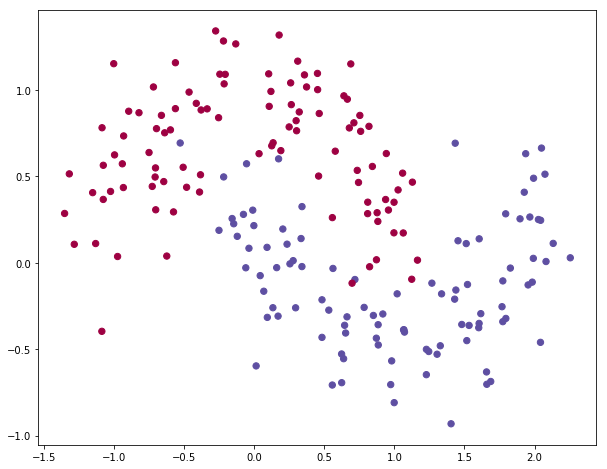

In [2]:
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(200, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)

In [3]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [4]:
# Size definitions
N = len(train_X)
input_size = 2 
hidden_size = 100
output_size = 2

reg=0.01 # reg strenght
epsilon=0.1  # learning rate

In [5]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

In [6]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(input_size, hidden_size), name='W1')
b1 = theano.shared(np.zeros(hidden_size), name='b1')
W2 = theano.shared(np.random.randn(hidden_size, output_size), name='W2')
b2 = theano.shared(np.zeros(output_size), name='b2')

In [7]:
# Forward pass
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
probs = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./N * reg/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(probs, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(probs, axis=1)

In [8]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], probs)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction, allow_input_downcast=True)

The output file is available at nn-theano-forward_prop.png


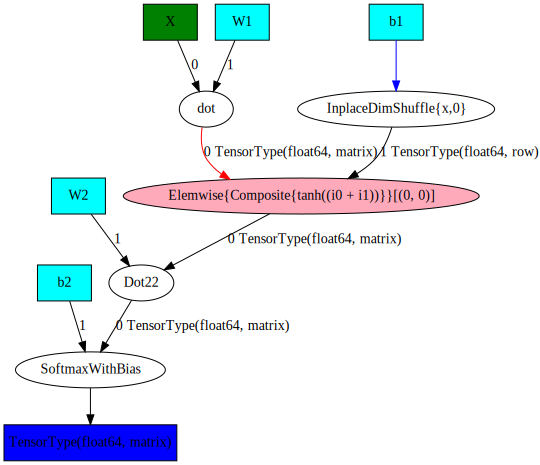

In [9]:
# Computational graph
theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, outfile='nn-theano-forward_prop', format='png')
SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

In [10]:
theano.printing.debugprint(forward_prop)

SoftmaxWithBias [id A] ''   4
 |Dot22 [id B] ''   3
 | |Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)] [id C] ''   2
 | | |dot [id D] ''   1
 | | | |X [id E]
 | | | |W1 [id F]
 | | |InplaceDimShuffle{x,0} [id G] ''   0
 | |   |b1 [id H]
 | |W2 [id I]
 |b2 [id J]


In [11]:
def show_legend():
    classes = ['Male','Pred male', 'Female', 'Pred female']
    class_colours = [plt.cm.get_cmap('Spectral')(0), plt.cm.get_cmap('binary_r')(0),
                     plt.cm.get_cmap('Spectral_r')(0), plt.cm.get_cmap('binary')(0)]
    recs = []
    for i in range(len(class_colours)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    return plt.legend(recs, classes, loc=1)

In [12]:
# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [13]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [14]:
input_size = 2 # input layer dimensionality -> position in the plane
output_size = 2 # output layer dimensionality -> male/female

def make_model(epochs=20000, decay=None, batch_size=None, print_loss=None):
 
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(input_size, hidden_size) / np.sqrt(input_size))
    b1.set_value(np.zeros(hidden_size))
    W2.set_value(np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size))
    b2.set_value(np.zeros(output_size))
    
    for i in range(epochs):
        
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss is not None and i % print_loss == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))

In [17]:
test_X, test_y = sklearn.datasets.make_moons(50, noise=0.20)
test_X = test_X.astype(np.float32)
test_y = test_y.astype(np.int32)

Loss after iteration 0: 1.001968
Loss after iteration 5000: 0.130772
Loss after iteration 10000: 0.104385
Loss after iteration 15000: 0.097935
Loss after iteration 20000: 0.095175
Loss after iteration 25000: 0.093614
Loss after iteration 30000: 0.092578
Loss after iteration 35000: 0.091835
Loss after iteration 40000: 0.091286
Loss after iteration 45000: 0.090875
Loss after iteration 50000: 0.090563
Loss after iteration 55000: 0.090325
Loss after iteration 60000: 0.090140
Loss after iteration 65000: 0.089996
Loss after iteration 70000: 0.089882
Loss after iteration 75000: 0.089791
Loss after iteration 0: 0.573668
Loss after iteration 5000: 0.077983
Loss after iteration 10000: 0.070649
Loss after iteration 15000: 0.069269
Loss after iteration 20000: 0.068731
Loss after iteration 25000: 0.068459
Loss after iteration 30000: 0.068297
Loss after iteration 35000: 0.068191
Loss after iteration 40000: 0.068116
Loss after iteration 45000: 0.068060
Loss after iteration 50000: 0.068017
Loss after 

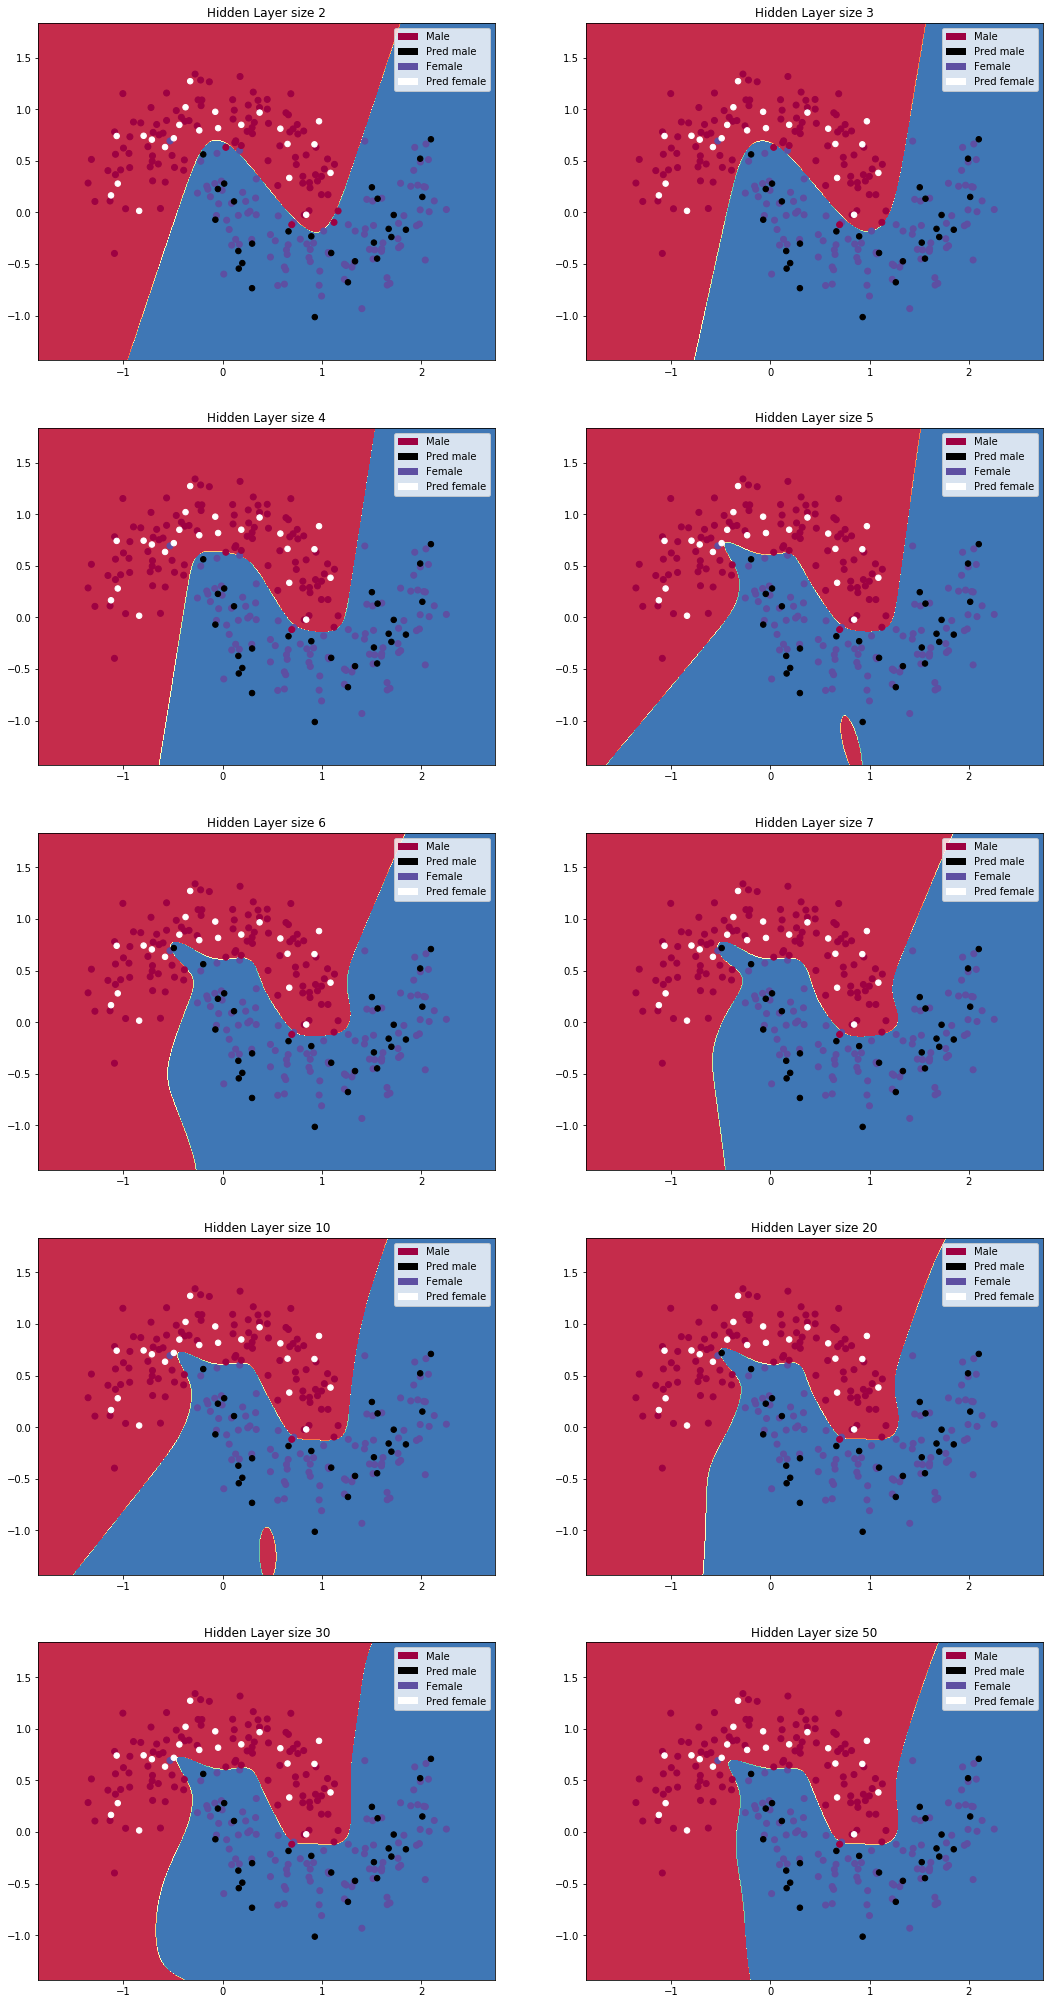

In [25]:
plt.figure(figsize=(18, 36))
hidden_sizes = [2, 3, 4, 5, 6, 7, 10, 20, 30, 50]

for i, hidden_size in enumerate(hidden_sizes):
    hidden_size = hidden_sizes[i]
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(epochs=75001, print_loss=5000)
    predictions = predict(test_X)
    plot_decision_boundary(lambda x: predict(x))
    plt.scatter(test_X[:,0], test_X[:,1], s=30, c=predictions, cmap=plt.cm.binary)
    show_legend()
plt.show()